In [1]:
import os, sys, time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse, Arc
import matplotlib.patheffects as patheffects
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.io import fits
from astropy.visualization import (AsinhStretch, LinearStretch, ImageNormalize)

import frank
from frank.radial_fitters import FrankFitter
from frank.geometry import FixedGeometry
from frank.utilities import convolve_profile, sweep_profile
from frank.io import save_fit, load_sol
from frank.make_figs import make_full_fig
from gofish import imagecube  # for the CLEAN profile
sys.path.append('./')
import diskdictionary as disk

from scipy import signal
arcsec = 1/3600 * np.pi/180
deg = np.pi/180
from scipy.integrate import simpson
from scipy.interpolate import CubicSpline, interp1d

In [2]:
##### MODIFY HERE #####

target = 'AA_Tau'
target_label = 'AA Tau'

img_lims = 1.1
res_vmin, res_vmax = -5, 5
index_ticks = 0.5

RMS_data = 0.022    #mJy

# load data
data_fits = f'CLEAN/{target}_data.fits'
dhdu = fits.open(data_fits)
dimg, hd = np.squeeze(dhdu[0].data), dhdu[0].header

# Load frank fit
sol = load_sol(f'fits/{target}_frank_sol.obj')
r_frank = sol.r
Inu_frank = sol.I

# load residual image
rhdu = fits.open(f'CLEAN/{target}_resid.fits')
rimg = np.squeeze(rhdu[0].data)

# load model image
mhdu = fits.open(f'CLEAN/{target}_model.fits')
mimg = np.squeeze(mhdu[0].data)

In [3]:

# parse coordinate frame indices into physical numbers
RA = 3600 * hd['CDELT1'] * (np.arange(hd['NAXIS1']) - (hd['CRPIX1'] - 1)) 
DEC = 3600 * hd['CDELT2'] * (np.arange(hd['NAXIS2']) - (hd['CRPIX2'] - 1))
dRA, dDEC = np.meshgrid(RA - disk.disk[target]['dx'], 
                        DEC - disk.disk[target]['dy'])
freq = hd['CRVAL3']

# image setups
rout = disk.disk[target]['rout']
im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())
#im_bounds_au = np.asarray(im_bounds)*distance_pc
dRA_lims, dDEC_lims = [img_lims*rout, -img_lims*rout], [-img_lims*rout, img_lims*rout]
#dRA_lims_au = np.asarray(dRA_lims)*distance_pc
#dDEC_lims_au = np.asarray(dDEC_lims)*distance_pc

# residuals color map
c2 = plt.cm.Reds(np.linspace(0, 1, 32))
c1 = plt.cm.Blues_r(np.linspace(0, 1, 32))
c1 = np.vstack([c1, np.ones((32, 4))])
colors = np.vstack((c1, c2))
mymap = mcolors.LinearSegmentedColormap.from_list('eddymap', colors)

separations = 20   # discrete colorbar
discrete_colors = plt.get_cmap(mymap)(np.linspace(0,1,separations))
discrete_cmap = mcolors.ListedColormap(discrete_colors) 

# beam parameters
bmaj, bmin, bPA = 3600 * hd['BMAJ'], 3600 * hd['BMIN'], hd['BPA']
beam_area = (np.pi * bmaj * bmin / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

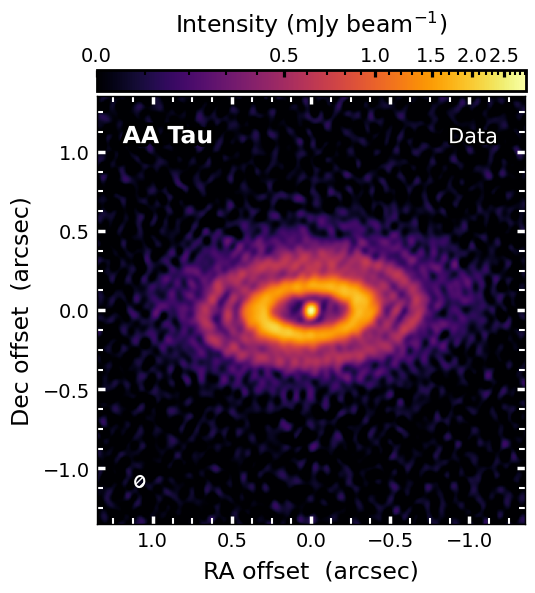

In [4]:
##########################
### Plot the data image
##########################

fig = plt.figure(figsize=(7.0, 5.9))
ax0 = fig.add_subplot(111)

# intensity limits, and stretch
norm = ImageNormalize(vmin=0, vmax=np.nan_to_num(dimg).max()*1e3, stretch=AsinhStretch())
cmap = 'inferno'
im0 = ax0.imshow(dimg*1e3, origin='lower', cmap=cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar0 = fig.colorbar(im0, ax=ax0, pad=0.01, location='top', fraction=0.0472)
cbar0.outline.set_linewidth(2)
cbar0.ax.tick_params(which='major', labelsize=14,width=2.3, length=5,direction='in')
cbar0.ax.tick_params(which='minor', labelsize=14,width=1.5, length=3.5,direction='in')
cbar0.set_label('Intensity (mJy $\mathrm{beam}^{-1}$)', labelpad=10, fontsize = 17)
#cbar0.set_ticks([0,0.5,1])
cbar0.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='w', lw=1.5, facecolor='none', hatch='/////')
ax0.add_artist(beam)

# Write source name
ax0.text(0.06, 0.89, s=target_label,
        transform=ax0.transAxes, color='w', fontsize=17, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="k")])

ax0.text(0.82, 0.89, "Data",
        transform=ax0.transAxes, color='w', fontsize=15,
        path_effects=[patheffects.withStroke(linewidth=3, foreground="k")])

# limits, labeling
ax0.set_xlim(dRA_lims)
ax0.set_ylim(dDEC_lims)

# axes style
ax0.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax0.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax0.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax0.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax0.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=5,width=2.5, length=6,direction='in',color='w')
ax0.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=5,width=1.5, length=4,direction='in',color='w')
ax0.set_xlabel('RA offset  (arcsec)', fontsize = 17, labelpad=7)
ax0.set_ylabel('Dec offset  (arcsec)', fontsize = 17, labelpad=7)


for side in ax0.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax0.spines[side].set_linewidth(1)

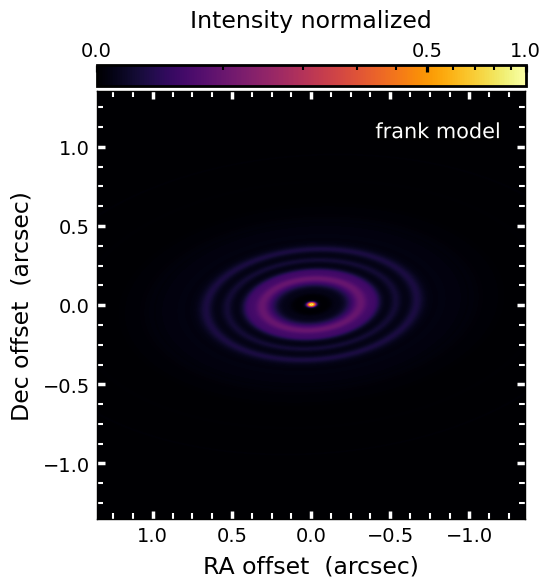

In [5]:
##########################
### Plot the frank sweep
##########################

fig = plt.figure(figsize=(7.0, 5.9))
ax1 = fig.add_subplot(111)

sweep_img = sweep_profile(r_frank, Inu_frank, project=True, geom=sol.geometry, dr=1e-3)
sweep_img_norm = sweep_img[0] / np.nan_to_num(Inu_frank).max()
im_bounds_sweep = (sweep_img[1], -sweep_img[1], -sweep_img[2], sweep_img[2])

# intensity limits, and stretch

norm = ImageNormalize(vmin=0, vmax=1, stretch=AsinhStretch())
cmap = 'inferno'
im1 = ax1.imshow(sweep_img_norm, origin='lower', cmap=cmap, extent=im_bounds_sweep, norm=norm)


# add scalebars
cbar0 = fig.colorbar(im1, ax=ax1, pad=0.01, location='top', fraction=0.0472)
cbar0.outline.set_linewidth(2)
cbar0.ax.tick_params(which='major', labelsize=14,width=2.3, length=5,direction='in')
cbar0.ax.tick_params(which='minor', labelsize=14,width=1.5, length=3.5,direction='in')
cbar0.set_label('Intensity normalized', labelpad=10, fontsize = 17)
cbar0.set_ticks([0,0.5,1])
cbar0.ax.minorticks_on()


# Write source name

ax1.text(0.65, 0.89, "frank model",
        transform=ax1.transAxes, color='w', fontsize=15,
        path_effects=[patheffects.withStroke(linewidth=3, foreground="k")])

# limits, labeling
ax1.set_xlim(dRA_lims)
ax1.set_ylim(dDEC_lims)

# axes style
ax1.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax1.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax1.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax1.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax1.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=5,width=2.5, length=6,direction='in',color='w')
ax1.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=5,width=1.5, length=4,direction='in',color='w')
ax1.set_xlabel('RA offset  (arcsec)', fontsize = 17, labelpad=7)
ax1.set_ylabel('Dec offset  (arcsec)', fontsize = 17, labelpad=7)


for side in ax1.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax1.spines[side].set_linewidth(1)

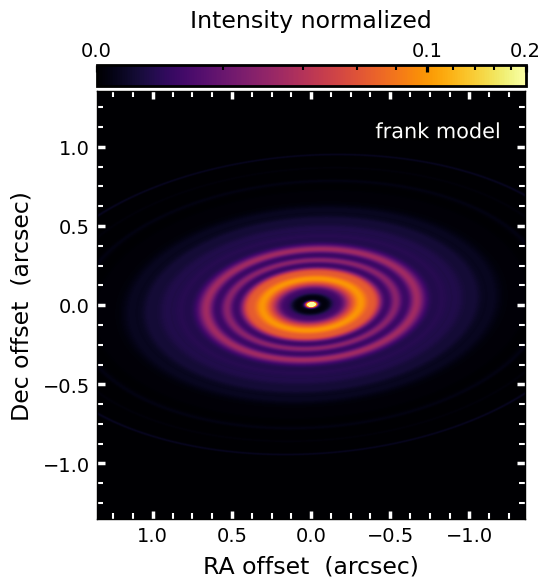

In [6]:
##########################
### Plot the frank sweep
##########################

fig = plt.figure(figsize=(7.0, 5.9))
ax1 = fig.add_subplot(111)

sweep_img = sweep_profile(r_frank, Inu_frank, project=True, geom=sol.geometry, dr=1e-3)
sweep_img_norm = sweep_img[0] / np.nan_to_num(Inu_frank).max()
im_bounds_sweep = (sweep_img[1], -sweep_img[1], -sweep_img[2], sweep_img[2])

# intensity limits, and stretch

norm = ImageNormalize(vmin=0, vmax=0.2, stretch=AsinhStretch())
cmap = 'inferno'
im1 = ax1.imshow(sweep_img_norm, origin='lower', cmap=cmap, extent=im_bounds_sweep, norm=norm)


# add scalebars
cbar0 = fig.colorbar(im1, ax=ax1, pad=0.01, location='top', fraction=0.0472)
cbar0.outline.set_linewidth(2)
cbar0.ax.tick_params(which='major', labelsize=14,width=2.3, length=5,direction='in')
cbar0.ax.tick_params(which='minor', labelsize=14,width=1.5, length=3.5,direction='in')
cbar0.set_label('Intensity normalized', labelpad=10, fontsize = 17)
cbar0.set_ticks([0,0.1, 0.2])
cbar0.ax.minorticks_on()


# Write source name

ax1.text(0.65, 0.89, "frank model",
        transform=ax1.transAxes, color='w', fontsize=15,
        path_effects=[patheffects.withStroke(linewidth=3, foreground="k")])

# limits, labeling
ax1.set_xlim(dRA_lims)
ax1.set_ylim(dDEC_lims)

# axes style
ax1.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax1.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax1.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax1.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax1.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=5,width=2.5, length=6,direction='in',color='w')
ax1.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=5,width=1.5, length=4,direction='in',color='w')
ax1.set_xlabel('RA offset  (arcsec)', fontsize = 17, labelpad=7)
ax1.set_ylabel('Dec offset  (arcsec)', fontsize = 17, labelpad=7)


for side in ax1.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax1.spines[side].set_linewidth(1)

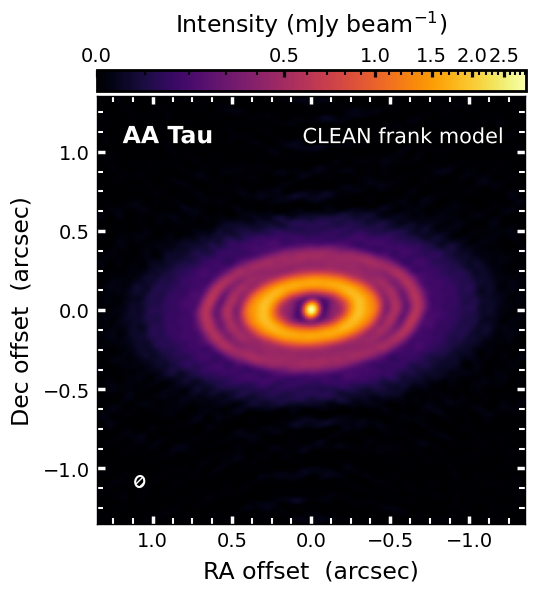

In [7]:
###############################
### Plot the model CLEAN image
###############################

fig = plt.figure(figsize=(7.0, 5.9))
ax0 = fig.add_subplot(111)

# intensity limits, and stretch
norm = ImageNormalize(vmin=0, vmax=np.nan_to_num(dimg).max()*1e3, stretch=AsinhStretch())
cmap = 'inferno'
im0 = ax0.imshow(mimg*1e3, origin='lower', cmap=cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar0 = fig.colorbar(im0, ax=ax0, pad=0.01, location='top', fraction=0.0472)
cbar0.outline.set_linewidth(2)
cbar0.ax.tick_params(which='major', labelsize=14,width=2.3, length=5,direction='in')
cbar0.ax.tick_params(which='minor', labelsize=14,width=1.5, length=3.5,direction='in')
cbar0.set_label('Intensity (mJy $\mathrm{beam}^{-1}$)', labelpad=10, fontsize = 17)
#cbar0.set_ticks([0,0.5,1])
cbar0.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='w', lw=1.5, facecolor='none', hatch='/////')
ax0.add_artist(beam)

# Write source name
ax0.text(0.06, 0.89, s=target_label,
        transform=ax0.transAxes, color='w', fontsize=17, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="k")])

ax0.text(0.48, 0.89, "CLEAN frank model",
        transform=ax0.transAxes, color='w', fontsize=15,
        path_effects=[patheffects.withStroke(linewidth=3, foreground="k")])

# limits, labeling
ax0.set_xlim(dRA_lims)
ax0.set_ylim(dDEC_lims)

# axes style
ax0.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax0.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax0.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax0.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax0.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=5,width=2.5, length=6,direction='in',color='w')
ax0.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=5,width=1.5, length=4,direction='in',color='w')
ax0.set_xlabel('RA offset  (arcsec)', fontsize = 17, labelpad=7)
ax0.set_ylabel('Dec offset  (arcsec)', fontsize = 17, labelpad=7)


for side in ax0.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax0.spines[side].set_linewidth(1)

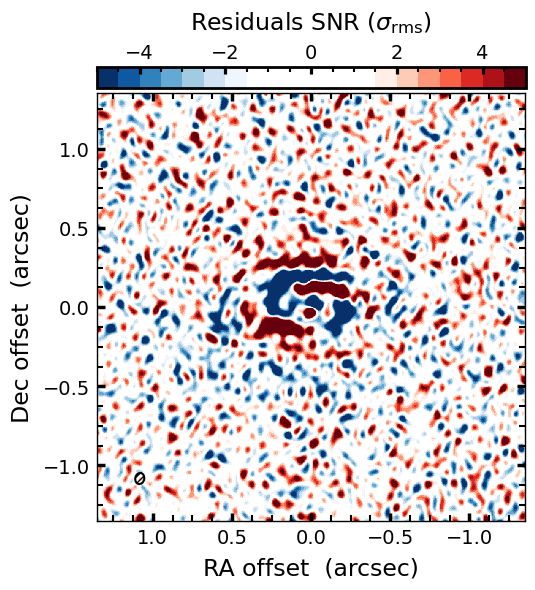

In [8]:
##########################
### Plot the residuals
##########################

fig = plt.figure(figsize=(7.0, 5.9))
ax2 = fig.add_subplot(111)

# intensity limits, and stretch
norm = ImageNormalize(vmin=res_vmin, vmax=res_vmax, stretch=LinearStretch())
im0 = ax2.imshow(rimg*1e3/RMS_data, origin='lower', cmap=discrete_cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar0 = fig.colorbar(im0, ax=ax2, pad=0.01, location='top', fraction=0.0472)
cbar0.outline.set_linewidth(2)
cbar0.ax.tick_params(which='major', labelsize=14,width=2.3, length=5,direction='in')
cbar0.ax.tick_params(which='minor', labelsize=14,width=1.5, length=3.5,direction='in')
cbar0.set_label('Residuals SNR ($\sigma_\mathrm{rms}$)', labelpad=10, fontsize = 17)
cbar0.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='k', lw=1.5, facecolor='none', hatch='/////')
ax2.add_artist(beam)




# limits, labeling
ax2.set_xlim(dRA_lims)
ax2.set_ylim(dDEC_lims)

# axes style
ax2.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax2.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax2.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax2.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax2.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=5,width=2.5, length=6,direction='in',color='k')
ax2.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=5,width=1.5, length=4,direction='in',color='k')
ax2.set_xlabel('RA offset  (arcsec)', fontsize = 17, labelpad=7)
ax2.set_ylabel('Dec offset  (arcsec)', fontsize = 17, labelpad=7)


for side in ax2.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax2.spines[side].set_linewidth(1)

In [9]:
#############################
### Plot the radial profile
############################

# Obtain the CLEAN profile using the imagecube function from gofish
cube = imagecube(data_fits, FOV=5.)

r_clean, I_clean, dI_clean = cube.radial_profile(x0=disk.disk[target]['dx'], y0=disk.disk[target]['dy'], inc=disk.disk[target]['incl'], PA=disk.disk[target]['PA'], dr=1/50)
def _calculate_flux_jy_sr(data,bmin,bmaj):
    omega = np.radians(bmin / 3600.)
    omega *= np.radians(bmaj / 3600.)
    beam_area = np.pi * omega / 4. / np.log(2.)
    return data / beam_area

I_clean_b  = _calculate_flux_jy_sr( I_clean,cube.bmin,cube.bmaj)
dI_clean_b = _calculate_flux_jy_sr(dI_clean,cube.bmin,cube.bmaj)

clean_beam = {'bmaj':bmaj, 'bmin':bmin, 'beam_pa':bPA}
Inu_frank_convolved = convolve_profile(r_frank, Inu_frank, disk.disk[target]['incl'], disk.disk[target]['PA'], clean_beam)


# convert to brightness temperatures (R-J limit)
#Tb_clean = c_**2 * 1e-23 * I_clean_b / (2 * k_ * freq**2)
#dTb_clean = c_**2 * 1e-23 * dI_clean_b / (2 * k_ * freq**2)
#Tb_frank = c_**2 * 1e-23 * Inu_frank / (2 * k_ * freq**2)
#Tb_frank_interp = interp1d(r_frank*distance_pc, Tb_frank)

#Inu_frank_interp = interp1d(r_frank*distance_pc, Inu_frank)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


(10000000.0, 500000000000.0)

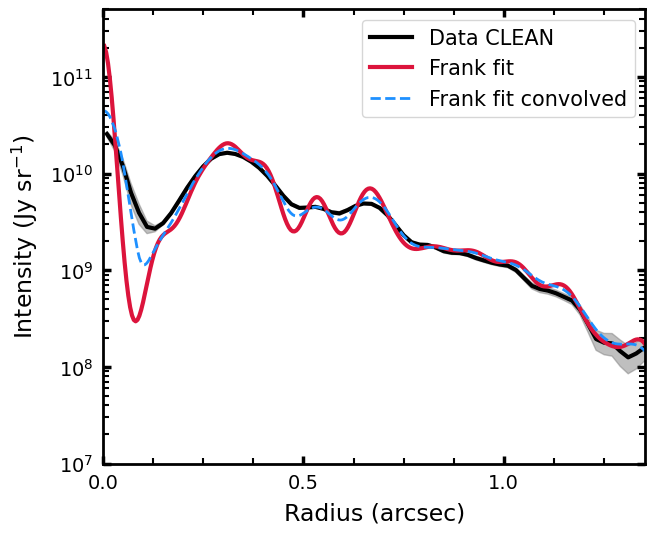

In [10]:
fig = plt.figure(figsize=(7, 5.9))
ax3 = fig.add_subplot(111)

ax3.fill_between(r_clean, I_clean_b-dI_clean_b, I_clean_b+dI_clean_b, color='gray', alpha=0.5)
ax3.plot(r_clean, I_clean_b, 'k', lw=3, label='Data CLEAN')
ax3.plot(r_frank, Inu_frank, 'crimson', lw=3, label='Frank fit')
ax3.plot(r_frank[Inu_frank_convolved>0], Inu_frank_convolved[Inu_frank_convolved>0], 'dodgerblue', lw=2, linestyle='dashed', label='Frank fit convolved')


ax3.set_xlim([0, img_lims*rout])
xindex_ticks = 0.5
ax3.xaxis.set_major_locator(MultipleLocator(xindex_ticks))
ax3.xaxis.set_minor_locator(MultipleLocator(xindex_ticks/4))

ax3.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=7,width=2.5, length=6,direction='in',color='k')
ax3.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=7,width=1.5, length=4,direction='in',color='k')
ax3.set_xlabel('Radius (arcsec)', fontsize = 17, labelpad=7)
ax3.set_ylabel('Intensity (Jy sr$^{-1}$)', fontsize = 17, labelpad=7)
ax3.legend(fontsize=15)

for side in ax3.spines.keys():
    ax3.spines[side].set_linewidth(2) 

ax3.set_yscale('log')
ymin=1e7
ymax=5e11
ax3.set_ylim([ymin, ymax]) 

Total flux = 191.49 mJy
R_68 = 0.685 arcsec = 92.2 au
R_90 = 1.035 arcsec = 139.4 au
R_95 = 1.177 arcsec = 158.6 au
All frank local maxima within R90: [0.31191288 0.53289815 0.66641021 0.82294162 0.91041507 1.01630399]
All frank local minima within R90: [0.08172193 0.4776518  0.59274838 0.78150683 0.88739574 0.98868079]


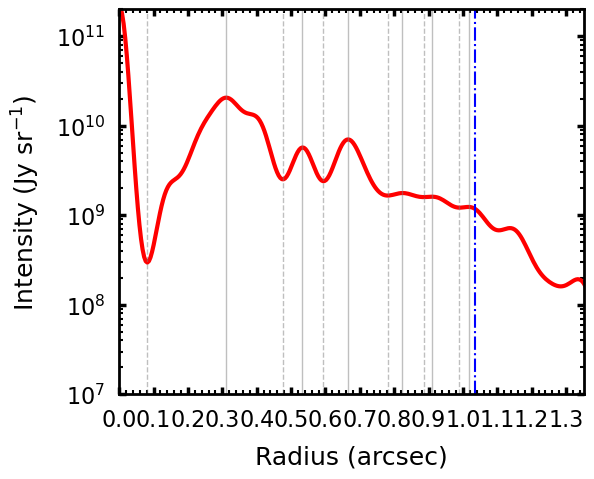

In [11]:
##########################
### From frank profile ###
##########################

integrand  = 2*np.pi*r_frank*arcsec*Inu_frank
cumulative = np.cumsum(integrand)
norm_numerical_cumulative = np.cumsum(integrand)/np.amax(np.cumsum(integrand))

tot_flux =  simpson(integrand, r_frank*arcsec) * np.cos(disk.disk[target]['incl']*deg) *1e3
print(f'Total flux = {tot_flux:.2f} mJy')

cumulative_tot_flux = np.zeros(integrand.shape[0])
for i in range(1, integrand.shape[0]):
    cumulative_tot_flux[i] = simpson(integrand[:i], r_frank[:i]*arcsec) * np.cos(disk.disk[target]['incl']*deg) *1e3
    
norm_cumulative_tot_flux = cumulative_tot_flux / np.amax(cumulative_tot_flux)
R_68_arcsec = r_frank[np.where(norm_cumulative_tot_flux <= 0.68)[0][-1]]
R_90_arcsec = r_frank[np.where(norm_cumulative_tot_flux <= 0.90)[0][-1]]
R_95_arcsec = r_frank[np.where(norm_cumulative_tot_flux <= 0.95)[0][-1]]

R_68_au = R_68_arcsec * disk.disk[target]['distance']
R_90_au = R_90_arcsec * disk.disk[target]['distance']
R_95_au = R_95_arcsec * disk.disk[target]['distance']

print(f'R_68 = {R_68_arcsec:.3g} arcsec = {(R_68_au):.3g} au\nR_90 = {R_90_arcsec:.3f} arcsec = {(R_90_au):.1f} au\nR_95 = {R_95_arcsec:.3f} arcsec = {(R_95_au):.1f} au')


# Find the indices for all possible local maxima and minima
i_locmax, _ = signal.find_peaks(Inu_frank)
i_locmin, _ = signal.find_peaks(-Inu_frank)

# RMS
bmaj, bmin, bPA = 3600 * hd['BMAJ'], 3600 * hd['BMIN'], hd['BPA']
beam_area = (np.pi * bmaj * bmin / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

# create an array conbining all the radial location (in arcsec) of all local maxima and minima within R_90%
r_locmax_inR90_RMS = r_frank[i_locmax][(r_frank[i_locmax] < R_90_arcsec)]
r_locmin_inR90_RMS = r_frank[i_locmin][(r_frank[i_locmin] < R_90_arcsec)]
r_allcand = np.sort(np.concatenate((r_locmax_inR90_RMS, r_locmin_inR90_RMS)))

# create an array conbining all the radial location (in arcsec) of all local maxima and minima within your favorite radius
#r_locmax_inR90_RMS = r_frank[i_locmax][(r_frank[i_locmax] < 0.16)]
#r_locmin_inR90_RMS = r_frank[i_locmin][(r_frank[i_locmin] < 0.16)]
#r_allcand = np.sort(np.concatenate((r_locmax_inR90_RMS, r_locmin_inR90_RMS)))

print(f'All frank local maxima within R90: {r_locmax_inR90_RMS}')
print(f'All frank local minima within R90: {r_locmin_inR90_RMS}')

r_gaps_arcsec = r_locmin_inR90_RMS
r_rings_arcsec = r_locmax_inR90_RMS

#############################################
### Plot frank profile with substructures ###
#############################################


fig = plt.figure(figsize=(6,5))
ax =fig.add_subplot()

ax.plot(r_frank, Inu_frank, color='r', linewidth=3)

for i in range(r_locmax_inR90_RMS.size):
    ax.axvline(r_locmax_inR90_RMS[i], color='gray', alpha=0.5, linewidth=1)
    
for i in range(r_locmin_inR90_RMS.size):
    ax.axvline(r_locmin_inR90_RMS[i], color='gray', linestyle='dashed', alpha=0.5, linewidth=1)

ax.axvline((R_90_arcsec), linestyle='dashdot', color='blue', linewidth=1.5)
#ax.axvline((R_95_arcsec), linestyle='dashdot', color='blue', linewidth=1.5)

ax.set_yscale('log')

index_xticks = 0.1
ax.xaxis.set_major_locator(MultipleLocator(index_xticks))
ax.xaxis.set_minor_locator(MultipleLocator(index_xticks/5))

ax.set_xlim(0, img_lims*rout)
ax.set_ylim(1e7,2e11)

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=16, pad=10,width=2.5, length=5,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=16, pad=10,width=1.5, length=3,direction='in',color='k')

ax.set_xlabel('Radius (arcsec)', fontsize = 18, labelpad=10)
ax.set_ylabel('Intensity (Jy sr$^{-1}$)', fontsize = 18, labelpad=10)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2) 

In [12]:
##### MODIFY HERE #####

img_lims = 1.1
dRA_lims, dDEC_lims = [img_lims*rout, -img_lims*rout], [-img_lims*rout, img_lims*rout]

index_ticks = 0.5
res_vmin, res_vmax = -5, 5
Rindex_ticks = 0.1
Rmax = img_lims*rout
setticks_cbar = [0,1.0, 2.0]

radprof_ymin=2e7
radprof_ymax=2e11

subs_theta_width = 45

####### Plot settings ################

axlabel_size = 17
axlabel_pad = 7
ticklabel_size = 14
txt_size = 15
name_size = 17

majtick_lenght = 5
majtick_width = 2.3
mintick_length = 3.5
mintick_width = 1.2

cmap = 'inferno'

# residuals color map
c2 = plt.cm.Reds(np.linspace(0, 1, 32))
c1 = plt.cm.Blues_r(np.linspace(0, 1, 32))
c1 = np.vstack([c1, np.ones((10, 4))])
colors = np.vstack((c1, c2))
mymap = mcolors.LinearSegmentedColormap.from_list('eddymap', colors)
separations = 20   # discrete colorbar
discrete_colors = plt.get_cmap(mymap)(np.linspace(0,1,separations))
discrete_cmap = mcolors.ListedColormap(discrete_colors) 

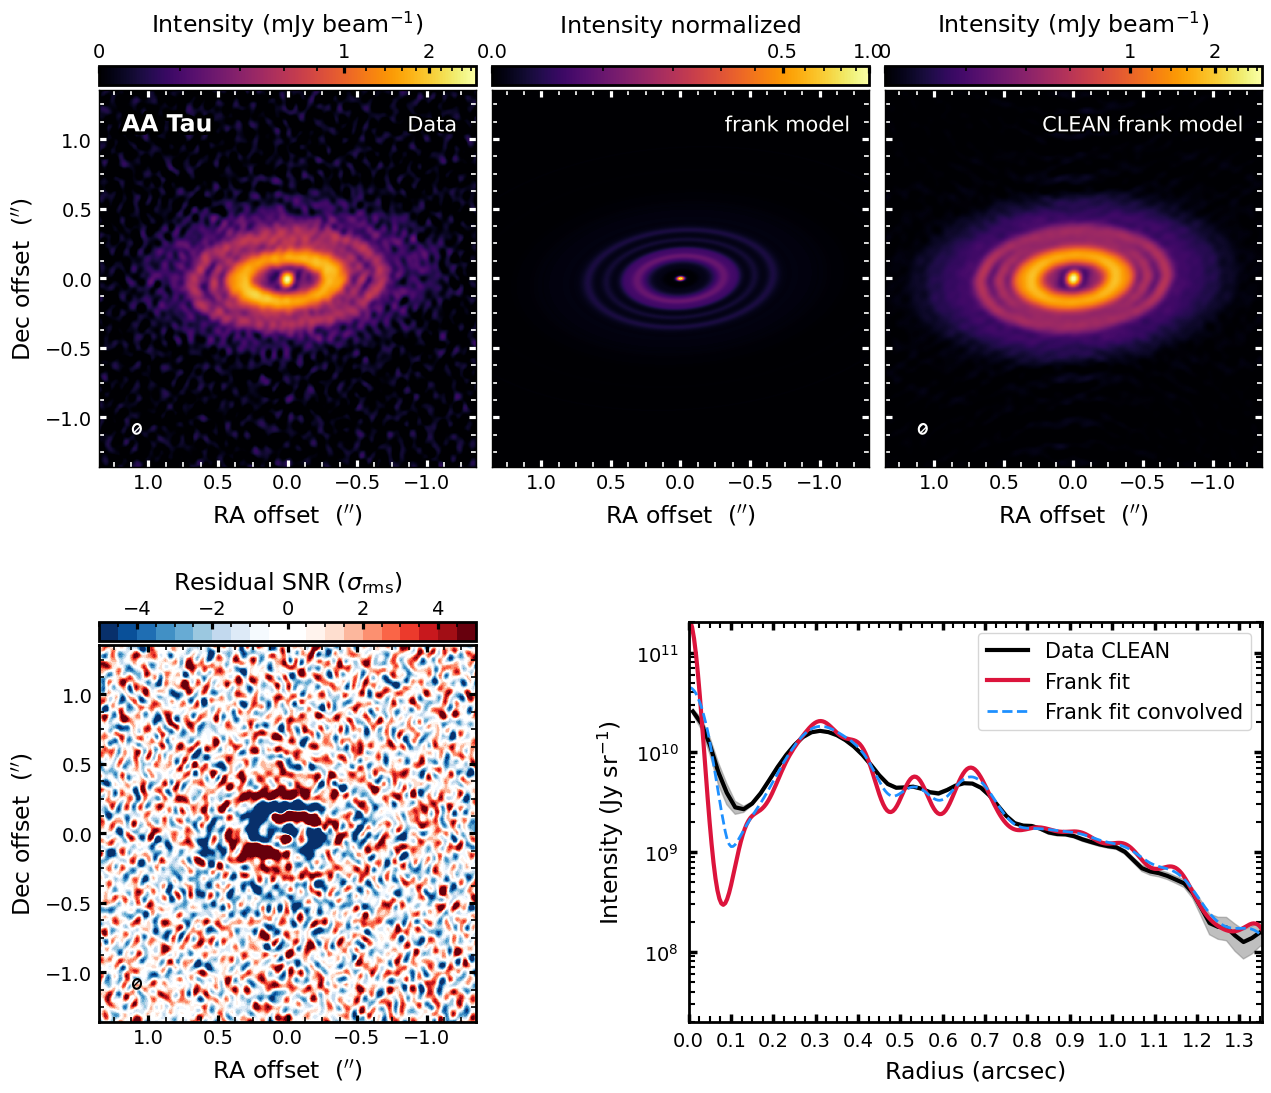

In [13]:
####################### Plot ###################################################################


fig = plt.figure(figsize=(15, 12.5))  
gs = gridspec.GridSpec(7, 12, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], height_ratios=[1, 1, 1, 1, 1, 1, 1])


#########################
####### Data ############
#########################

ax0 = plt.subplot(gs[0:4, 0:4])

norm = ImageNormalize(vmin=0, vmax=np.nan_to_num(dimg).max()*1e3, stretch=AsinhStretch())
im0 = ax0.imshow(dimg*1e3, origin='lower', cmap=cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar0 = fig.colorbar(im0, ax=ax0, pad=0.01, location='top', fraction=0.0472)
cbar0.outline.set_linewidth(2)
cbar0.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar0.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar0.set_label('Intensity (mJy $\mathrm{beam}^{-1}$)', labelpad=axlabel_pad, fontsize = axlabel_size)
cbar0.set_ticks(setticks_cbar)
cbar0.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='w', lw=1.5, facecolor='none', hatch='/////')
ax0.add_artist(beam)

# Write source name
ax0.text(0.06, 0.89, s=target_label,
        transform=ax0.transAxes, color='w', fontsize=name_size, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="k")])

ax0.text(0.95, 0.89, "Data",
        transform=ax0.transAxes, color='w', fontsize=txt_size,
        path_effects=[patheffects.withStroke(linewidth=3, foreground="k")], ha='right')

# limits, labeling
ax0.set_xlim(dRA_lims)
ax0.set_ylim(dDEC_lims)

# axes style

ax0.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax0.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax0.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax0.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax0.tick_params(which='major',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='in',color='w')
ax0.tick_params(which='minor',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='in',color='w')
ax0.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)
ax0.set_ylabel('Dec offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)


for side in ax0.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax0.spines[side].set_linewidth(1)


################################
####### frank sweep ############
################################

ax1 = plt.subplot(gs[0:4, 4:8])

sweep_img = sweep_profile(r_frank, Inu_frank, project=True, geom=sol.geometry, dr=1e-3)
sweep_img_norm = sweep_img[0] / np.nan_to_num(Inu_frank).max()
im_bounds_sweep = (sweep_img[1], -sweep_img[1], -sweep_img[2], sweep_img[2])

# intensity limits, and stretch

norm = ImageNormalize(vmin=0, vmax=1, stretch=AsinhStretch())
im1 = ax1.imshow(sweep_img_norm, origin='lower', cmap=cmap, extent=im_bounds_sweep, norm=norm)

# add scalebars
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.01, location='top', fraction=0.0472)
cbar1.outline.set_linewidth(2)
cbar1.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar1.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar1.set_label('Intensity normalized', labelpad=axlabel_pad, fontsize = axlabel_size)
cbar1.set_ticks([0,0.5,1])
cbar1.ax.minorticks_on()


# Write source name

ax1.text(0.95, 0.89, "frank model",
        transform=ax1.transAxes, color='w', fontsize=txt_size,
        path_effects=[patheffects.withStroke(linewidth=3, foreground="k")], ha='right')

# limits, labeling
ax1.set_xlim(dRA_lims)
ax1.set_ylim(dDEC_lims)

# axes style
ax1.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax1.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax1.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax1.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax1.tick_params(which='major',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='in',color='w')
ax1.tick_params(which='minor',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='in',color='w')
ax1.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)
ax1.set_yticklabels([])


for side in ax1.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax1.spines[side].set_linewidth(1)
    

################################
####### frank CLEAN ############
################################


ax2 = plt.subplot(gs[0:4, 8:12])

norm = ImageNormalize(vmin=0, vmax=np.nan_to_num(dimg).max()*1e3, stretch=AsinhStretch())
im2 = ax2.imshow(mimg*1e3, origin='lower', cmap=cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar2 = fig.colorbar(im2, ax=ax2, pad=0.01, location='top', fraction=0.0472)
cbar2.outline.set_linewidth(2)
cbar2.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar2.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar2.set_label('Intensity (mJy $\mathrm{beam}^{-1}$)', labelpad=axlabel_pad, fontsize = axlabel_size)
cbar2.set_ticks(setticks_cbar)
cbar2.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='w', lw=1.5, facecolor='none', hatch='/////')
ax2.add_artist(beam)

# Write source name

ax2.text(0.95, 0.89, "CLEAN frank model",
        transform=ax2.transAxes, color='w', fontsize=txt_size,
        path_effects=[patheffects.withStroke(linewidth=3, foreground="k")], ha='right')

# limits, labeling
ax2.set_xlim(dRA_lims)
ax2.set_ylim(dDEC_lims)

# axes style

ax2.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax2.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax2.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax2.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax2.tick_params(which='major',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='in',color='w')
ax2.tick_params(which='minor',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='in',color='w')
ax2.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)
ax2.set_yticklabels([])


for side in ax2.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax2.spines[side].set_linewidth(1)

##############################
####### Residuals ############
##############################

ax3 = plt.subplot(gs[4:8, 0:4])

# intensity limits, and stretch
norm = ImageNormalize(vmin=res_vmin, vmax=res_vmax, stretch=LinearStretch())
im3 = ax3.imshow(rimg*1e3/RMS_data, origin='lower', cmap=discrete_cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar3 = fig.colorbar(im3, ax=ax3, pad=0.01, location='top', fraction=0.0472)
cbar3.outline.set_linewidth(2)
cbar3.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar3.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar3.set_label('Residual SNR ($\sigma_\mathrm{rms}$)', labelpad=axlabel_pad, fontsize = axlabel_size)
cbar3.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='k', lw=1.5, facecolor='none', hatch='/////')
ax3.add_artist(beam)


# limits, labeling
ax3.set_xlim(dRA_lims)
ax3.set_ylim(dDEC_lims)

# axes style

ax3.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax3.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax3.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax3.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax3.tick_params(which='major',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='in',color='k')
ax3.tick_params(which='minor',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='in',color='k')
ax3.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)
ax3.set_ylabel('Dec offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)


for side in ax3.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax3.spines[side].set_linewidth(2)
    

###############################
####### Radial profile ############
###############################

ax4 = plt.subplot(gs[4:8, 6:12])  

ax4.fill_between(r_clean, I_clean_b-dI_clean_b, I_clean_b+dI_clean_b, color='gray', alpha=0.5)
ax4.plot(r_clean, I_clean_b, 'k', lw=3, label='Data CLEAN')
ax4.plot(r_frank, Inu_frank, 'crimson', lw=3, label='Frank fit')
ax4.plot(r_frank[Inu_frank_convolved>0], Inu_frank_convolved[Inu_frank_convolved>0], 'dodgerblue', lw=2, linestyle='dashed', label='Frank fit convolved')


ax4.set_xlim([0, img_lims*rout])
ax4.xaxis.set_major_locator(MultipleLocator(Rindex_ticks))
ax4.xaxis.set_minor_locator(MultipleLocator(Rindex_ticks/4))

ax4.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=7,width=2.5, length=6,direction='in',color='k')
ax4.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=7,width=1.5, length=4,direction='in',color='k')
ax4.set_xlabel('Radius (arcsec)', fontsize = 17, labelpad=7)
ax4.set_ylabel('Intensity (Jy sr$^{-1}$)', fontsize = 17, labelpad=7)
ax4.legend(fontsize=15)

for side in ax4.spines.keys():
    ax4.spines[side].set_linewidth(2) 

ax4.set_yscale('log')
ax4.set_ylim([radprof_ymin, radprof_ymax]) 

plt.savefig(f'{target}_data_frank_resid_profile_AsinhStretch.pdf', bbox_inches='tight') 
#plt.savefig(f'{target}_data_frank_resid_profile.png', bbox_inches='tight') 

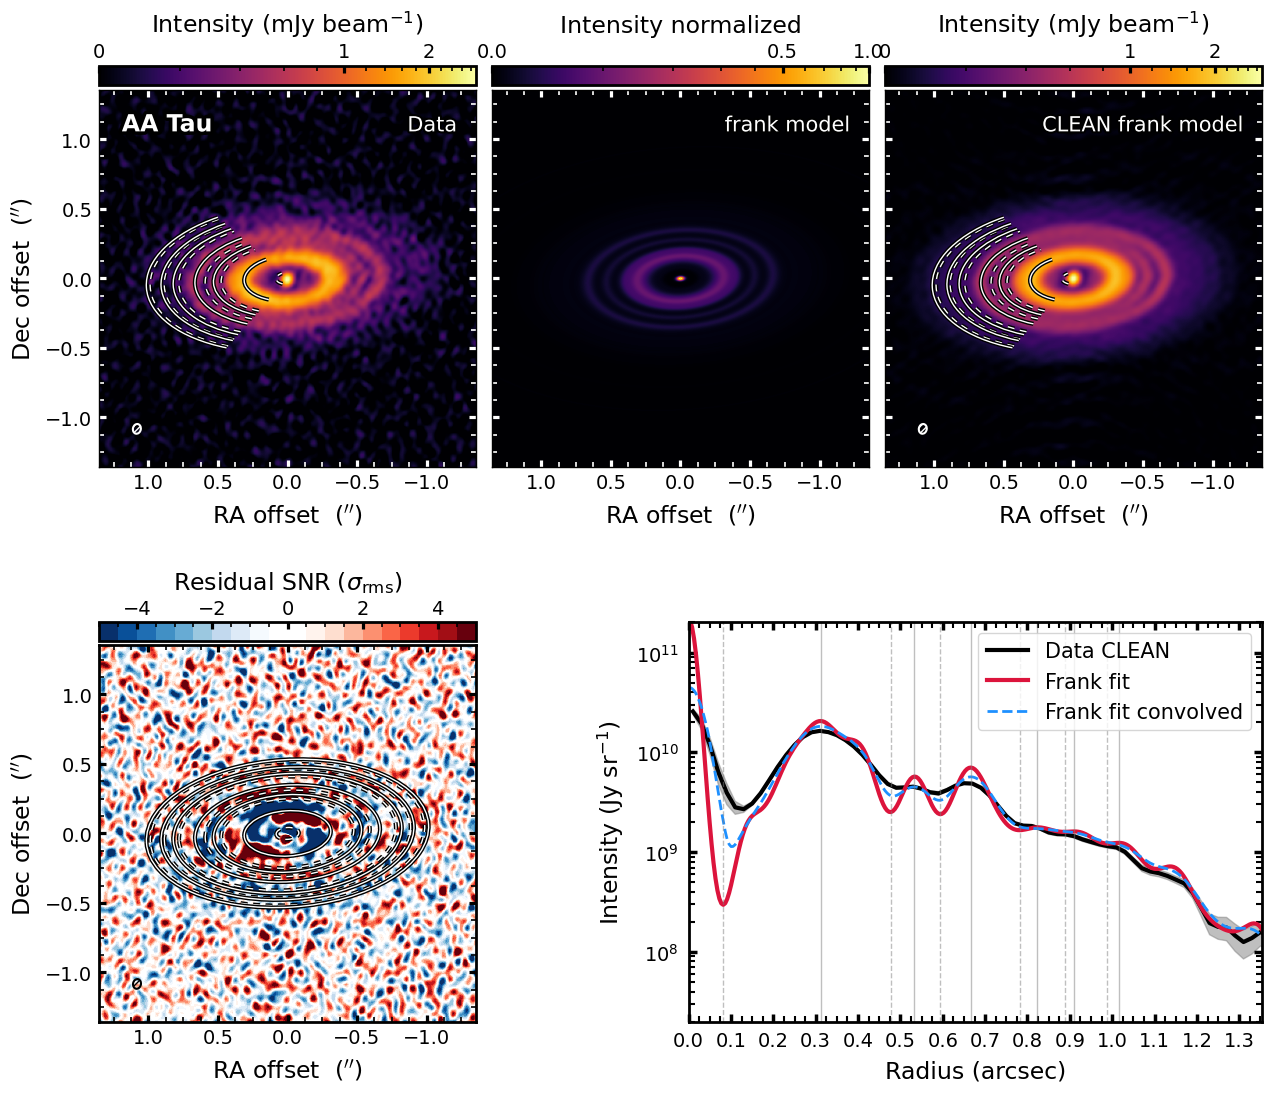

In [14]:
####################### Plot ###################################################################


fig = plt.figure(figsize=(15, 12.5))  
gs = gridspec.GridSpec(7, 12, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], height_ratios=[1, 1, 1, 1, 1, 1, 1])


#########################
####### Data ############
#########################

ax0 = plt.subplot(gs[0:4, 0:4])

norm = ImageNormalize(vmin=0, vmax=np.nan_to_num(dimg).max()*1e3, stretch=AsinhStretch())
im0 = ax0.imshow(dimg*1e3, origin='lower', cmap=cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar0 = fig.colorbar(im0, ax=ax0, pad=0.01, location='top', fraction=0.0472)
cbar0.outline.set_linewidth(2)
cbar0.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar0.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar0.set_label('Intensity (mJy $\mathrm{beam}^{-1}$)', labelpad=axlabel_pad, fontsize = axlabel_size)
cbar0.set_ticks(setticks_cbar)
cbar0.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='w', lw=1.5, facecolor='none', hatch='/////')
ax0.add_artist(beam)

# Write source name
ax0.text(0.06, 0.89, s=target_label,
        transform=ax0.transAxes, color='w', fontsize=name_size, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="k")])

ax0.text(0.95, 0.89, "Data",
        transform=ax0.transAxes, color='w', fontsize=txt_size,
        path_effects=[patheffects.withStroke(linewidth=3, foreground="k")], ha='right')

# limits, labeling
ax0.set_xlim(dRA_lims)
ax0.set_ylim(dDEC_lims)

# axes style

ax0.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax0.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax0.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax0.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax0.tick_params(which='major',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='in',color='w')
ax0.tick_params(which='minor',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='in',color='w')
ax0.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)
ax0.set_ylabel('Dec offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)


for side in ax0.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax0.spines[side].set_linewidth(1)

### Substrsuctures ###

outline=patheffects.withStroke(linewidth=3, foreground='k')

# Gaps
for s in range(r_gaps_arcsec.shape[0]):
    arc = Arc((0,0), r_gaps_arcsec[s]*2, r_gaps_arcsec[s]*np.cos(disk.disk[target]['incl']*np.pi/180)*2 , angle=90-disk.disk[target]['PA'], 
           theta1=-subs_theta_width, theta2=subs_theta_width, color='w', lw=1, linestyle=(0,(5,4)), path_effects=[outline])
    ax0.add_artist(arc)
# Rings
for s in range(r_rings_arcsec.shape[0]):
    arc = Arc((0,0), r_rings_arcsec[s]*2, r_rings_arcsec[s]*np.cos(disk.disk[target]['incl']*np.pi/180)*2 , angle=90-disk.disk[target]['PA'], 
           theta1=-subs_theta_width, theta2=subs_theta_width, color='w', lw=1, path_effects=[outline])
    ax0.add_artist(arc)


################################
####### frank sweep ############
################################

ax1 = plt.subplot(gs[0:4, 4:8])

sweep_img = sweep_profile(r_frank, Inu_frank, project=True, geom=sol.geometry, dr=1e-3)
sweep_img_norm = sweep_img[0] / np.nan_to_num(Inu_frank).max()
im_bounds_sweep = (sweep_img[1], -sweep_img[1], -sweep_img[2], sweep_img[2])

# intensity limits, and stretch

norm = ImageNormalize(vmin=0, vmax=1, stretch=AsinhStretch())
im1 = ax1.imshow(sweep_img_norm, origin='lower', cmap=cmap, extent=im_bounds_sweep, norm=norm)

# add scalebars
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.01, location='top', fraction=0.0472)
cbar1.outline.set_linewidth(2)
cbar1.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar1.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar1.set_label('Intensity normalized', labelpad=axlabel_pad, fontsize = axlabel_size)
cbar1.set_ticks([0,0.5,1])
cbar1.ax.minorticks_on()


# Write source name

ax1.text(0.95, 0.89, "frank model",
        transform=ax1.transAxes, color='w', fontsize=txt_size,
        path_effects=[patheffects.withStroke(linewidth=3, foreground="k")], ha='right')

# limits, labeling
ax1.set_xlim(dRA_lims)
ax1.set_ylim(dDEC_lims)

# axes style
ax1.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax1.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax1.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax1.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax1.tick_params(which='major',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='in',color='w')
ax1.tick_params(which='minor',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='in',color='w')
ax1.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)
ax1.set_yticklabels([])


for side in ax1.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax1.spines[side].set_linewidth(1)
    

################################
####### frank CLEAN ############
################################


ax2 = plt.subplot(gs[0:4, 8:12])

norm = ImageNormalize(vmin=0, vmax=np.nan_to_num(dimg).max()*1e3, stretch=AsinhStretch())
im2 = ax2.imshow(mimg*1e3, origin='lower', cmap=cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar2 = fig.colorbar(im2, ax=ax2, pad=0.01, location='top', fraction=0.0472)
cbar2.outline.set_linewidth(2)
cbar2.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar2.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar2.set_label('Intensity (mJy $\mathrm{beam}^{-1}$)', labelpad=axlabel_pad, fontsize = axlabel_size)
cbar2.set_ticks(setticks_cbar)
cbar2.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='w', lw=1.5, facecolor='none', hatch='/////')
ax2.add_artist(beam)

# Write source name

ax2.text(0.95, 0.89, "CLEAN frank model",
        transform=ax2.transAxes, color='w', fontsize=txt_size,
        path_effects=[patheffects.withStroke(linewidth=3, foreground="k")], ha='right')

# limits, labeling
ax2.set_xlim(dRA_lims)
ax2.set_ylim(dDEC_lims)

# axes style

ax2.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax2.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax2.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax2.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax2.tick_params(which='major',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='in',color='w')
ax2.tick_params(which='minor',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='in',color='w')
ax2.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)
ax2.set_yticklabels([])


for side in ax2.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax2.spines[side].set_linewidth(1)

### Substrsuctures ###

outline=patheffects.withStroke(linewidth=3, foreground='k')

# Gaps
for s in range(r_gaps_arcsec.shape[0]):
    arc = Arc((0,0), r_gaps_arcsec[s]*2, r_gaps_arcsec[s]*np.cos(disk.disk[target]['incl']*np.pi/180)*2 , angle=90-disk.disk[target]['PA'], 
           theta1=-subs_theta_width, theta2=subs_theta_width, color='w', lw=1, linestyle=(0,(5,4)), path_effects=[outline])
    ax2.add_artist(arc)
# Rings
for s in range(r_rings_arcsec.shape[0]):
    arc = Arc((0,0), r_rings_arcsec[s]*2, r_rings_arcsec[s]*np.cos(disk.disk[target]['incl']*np.pi/180)*2 , angle=90-disk.disk[target]['PA'], 
           theta1=-subs_theta_width, theta2=subs_theta_width, color='w', lw=1, path_effects=[outline])
    ax2.add_artist(arc)

##############################
####### Residuals ############
##############################

ax3 = plt.subplot(gs[4:8, 0:4])

# intensity limits, and stretch
norm = ImageNormalize(vmin=res_vmin, vmax=res_vmax, stretch=LinearStretch())
im3 = ax3.imshow(rimg*1e3/RMS_data, origin='lower', cmap=discrete_cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar3 = fig.colorbar(im3, ax=ax3, pad=0.01, location='top', fraction=0.0472)
cbar3.outline.set_linewidth(2)
cbar3.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar3.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar3.set_label('Residual SNR ($\sigma_\mathrm{rms}$)', labelpad=axlabel_pad, fontsize = axlabel_size)
cbar3.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='k', lw=1.5, facecolor='none', hatch='/////')
ax3.add_artist(beam)


# limits, labeling
ax3.set_xlim(dRA_lims)
ax3.set_ylim(dDEC_lims)

# axes style

ax3.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax3.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax3.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax3.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax3.tick_params(which='major',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='in',color='k')
ax3.tick_params(which='minor',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='in',color='k')
ax3.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)
ax3.set_ylabel('Dec offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)


for side in ax3.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax3.spines[side].set_linewidth(2)

### Substrsuctures ###

outline=patheffects.withStroke(linewidth=3, foreground='k')

# Gaps
for s in range(r_gaps_arcsec.shape[0]):
    arc = Arc((0,0), r_gaps_arcsec[s]*2, r_gaps_arcsec[s]*np.cos(disk.disk[target]['incl']*np.pi/180)*2 , angle=90-disk.disk[target]['PA'], 
           color='w', lw=1, linestyle=(0,(5,4)), path_effects=[outline])
    ax3.add_artist(arc)
# Rings
for s in range(r_rings_arcsec.shape[0]):
    arc = Arc((0,0), r_rings_arcsec[s]*2, r_rings_arcsec[s]*np.cos(disk.disk[target]['incl']*np.pi/180)*2 , angle=90-disk.disk[target]['PA'], 
           color='w', lw=1, path_effects=[outline])
    ax3.add_artist(arc)
    

###############################
####### Radial profile ############
###############################

ax4 = plt.subplot(gs[4:8, 6:12])  

ax4.fill_between(r_clean, I_clean_b-dI_clean_b, I_clean_b+dI_clean_b, color='gray', alpha=0.5)
ax4.plot(r_clean, I_clean_b, 'k', lw=3, label='Data CLEAN')
ax4.plot(r_frank, Inu_frank, 'crimson', lw=3, label='Frank fit')
ax4.plot(r_frank[Inu_frank_convolved>0], Inu_frank_convolved[Inu_frank_convolved>0], 'dodgerblue', lw=2, linestyle='dashed', label='Frank fit convolved')

for i in range(r_gaps_arcsec.size):
    ax4.axvline(r_gaps_arcsec[i], color='gray', linestyle='dashed', alpha=0.5, linewidth=1)

for i in range(r_rings_arcsec.size):
    ax4.axvline(r_rings_arcsec[i], color='gray', alpha=0.5, linewidth=1)
    
ax4.set_xlim([0, img_lims*rout])
ax4.xaxis.set_major_locator(MultipleLocator(Rindex_ticks))
ax4.xaxis.set_minor_locator(MultipleLocator(Rindex_ticks/4))

ax4.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=7,width=2.5, length=6,direction='in',color='k')
ax4.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=7,width=1.5, length=4,direction='in',color='k')
ax4.set_xlabel('Radius (arcsec)', fontsize = 17, labelpad=7)
ax4.set_ylabel('Intensity (Jy sr$^{-1}$)', fontsize = 17, labelpad=7)
ax4.legend(fontsize=15)

for side in ax4.spines.keys():
    ax4.spines[side].set_linewidth(2) 

ax4.set_yscale('log')
ax4.set_ylim([radprof_ymin, radprof_ymax]) 

plt.savefig(f'{target}_data_frank_resid_profile_AsinhStretch_subs.pdf', bbox_inches='tight') 
#plt.savefig(f'{target}_data_frank_resid_profile.png', bbox_inches='tight') 

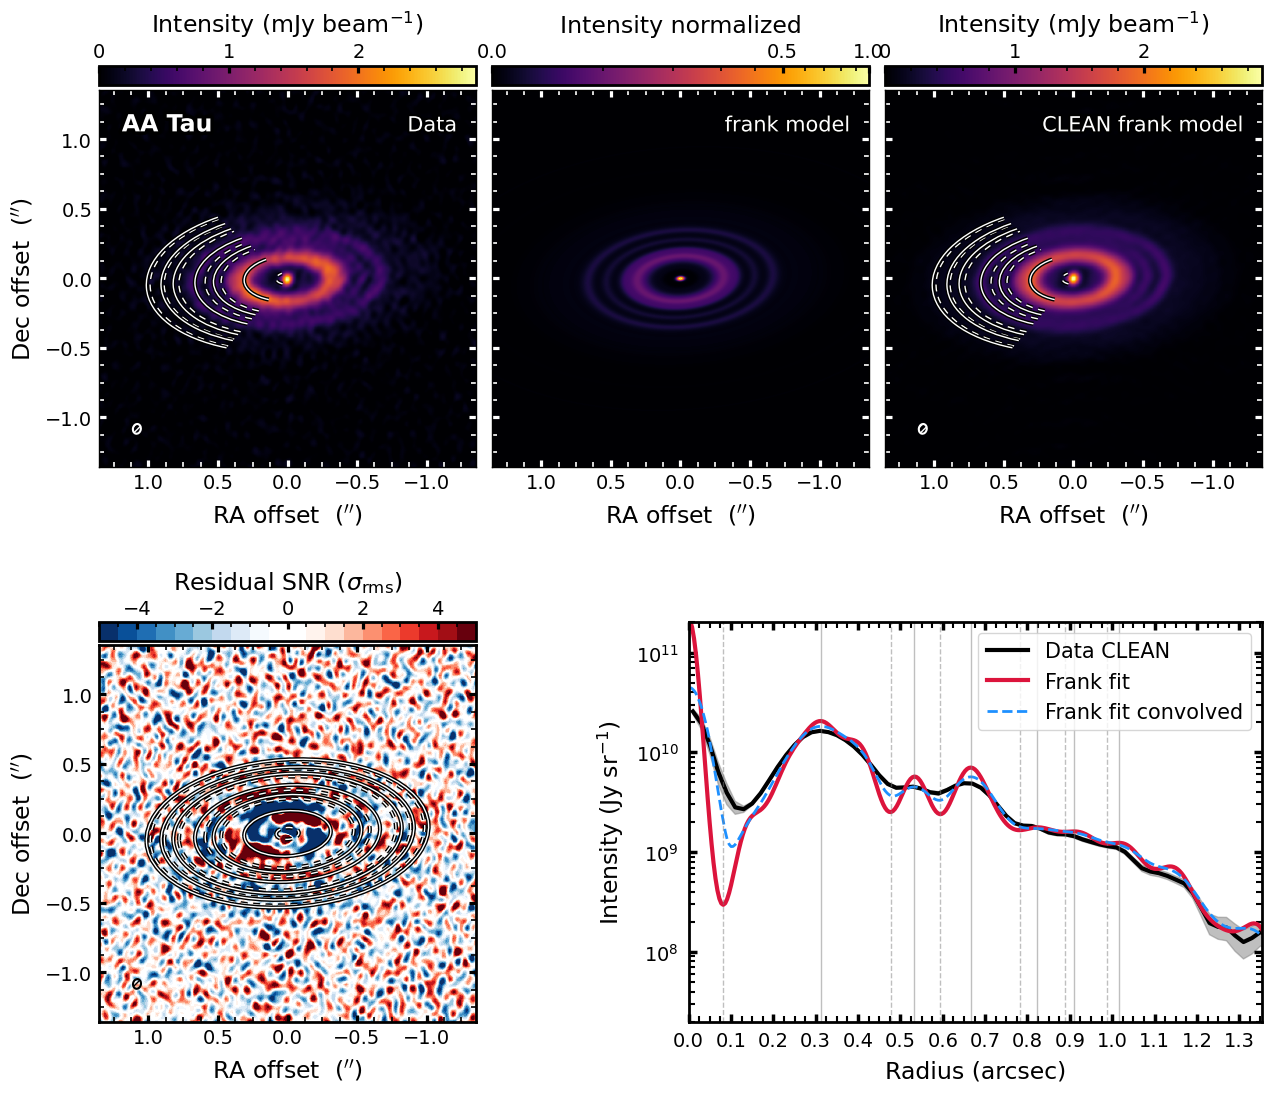

In [15]:
####################### Plot ###################################################################


fig = plt.figure(figsize=(15, 12.5))  
gs = gridspec.GridSpec(7, 12, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], height_ratios=[1, 1, 1, 1, 1, 1, 1])


#########################
####### Data ############
#########################

ax0 = plt.subplot(gs[0:4, 0:4])

norm = ImageNormalize(vmin=0, vmax=np.nan_to_num(dimg).max()*1e3, stretch=LinearStretch())
im0 = ax0.imshow(dimg*1e3, origin='lower', cmap=cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar0 = fig.colorbar(im0, ax=ax0, pad=0.01, location='top', fraction=0.0472)
cbar0.outline.set_linewidth(2)
cbar0.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar0.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar0.set_label('Intensity (mJy $\mathrm{beam}^{-1}$)', labelpad=axlabel_pad, fontsize = axlabel_size)
cbar0.set_ticks(setticks_cbar)
cbar0.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='w', lw=1.5, facecolor='none', hatch='/////')
ax0.add_artist(beam)

# Write source name
ax0.text(0.06, 0.89, s=target_label,
        transform=ax0.transAxes, color='w', fontsize=name_size, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="k")])

ax0.text(0.95, 0.89, "Data",
        transform=ax0.transAxes, color='w', fontsize=txt_size,
        path_effects=[patheffects.withStroke(linewidth=3, foreground="k")], ha='right')

# limits, labeling
ax0.set_xlim(dRA_lims)
ax0.set_ylim(dDEC_lims)

# axes style

ax0.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax0.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax0.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax0.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax0.tick_params(which='major',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='in',color='w')
ax0.tick_params(which='minor',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='in',color='w')
ax0.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)
ax0.set_ylabel('Dec offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)


for side in ax0.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax0.spines[side].set_linewidth(1)

### Substrsuctures ###

outline=patheffects.withStroke(linewidth=3, foreground='k')

# Gaps
for s in range(r_gaps_arcsec.shape[0]):
    arc = Arc((0,0), r_gaps_arcsec[s]*2, r_gaps_arcsec[s]*np.cos(disk.disk[target]['incl']*np.pi/180)*2 , angle=90-disk.disk[target]['PA'], 
           theta1=-subs_theta_width, theta2=subs_theta_width, color='w', lw=1, linestyle=(0,(5,4)), path_effects=[outline])
    ax0.add_artist(arc)
# Rings
for s in range(r_rings_arcsec.shape[0]):
    arc = Arc((0,0), r_rings_arcsec[s]*2, r_rings_arcsec[s]*np.cos(disk.disk[target]['incl']*np.pi/180)*2 , angle=90-disk.disk[target]['PA'], 
           theta1=-subs_theta_width, theta2=subs_theta_width, color='w', lw=1, path_effects=[outline])
    ax0.add_artist(arc)


################################
####### frank sweep ############
################################

ax1 = plt.subplot(gs[0:4, 4:8])

sweep_img = sweep_profile(r_frank, Inu_frank, project=True, geom=sol.geometry, dr=1e-3)
sweep_img_norm = sweep_img[0] / np.nan_to_num(Inu_frank).max()
im_bounds_sweep = (sweep_img[1], -sweep_img[1], -sweep_img[2], sweep_img[2])

# intensity limits, and stretch

norm = ImageNormalize(vmin=0, vmax=1, stretch=AsinhStretch())
im1 = ax1.imshow(sweep_img_norm, origin='lower', cmap=cmap, extent=im_bounds_sweep, norm=norm)

# add scalebars
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.01, location='top', fraction=0.0472)
cbar1.outline.set_linewidth(2)
cbar1.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar1.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar1.set_label('Intensity normalized', labelpad=axlabel_pad, fontsize = axlabel_size)
cbar1.set_ticks([0,0.5,1])
cbar1.ax.minorticks_on()


# Write source name

ax1.text(0.95, 0.89, "frank model",
        transform=ax1.transAxes, color='w', fontsize=txt_size,
        path_effects=[patheffects.withStroke(linewidth=3, foreground="k")], ha='right')

# limits, labeling
ax1.set_xlim(dRA_lims)
ax1.set_ylim(dDEC_lims)

# axes style
ax1.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax1.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax1.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax1.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax1.tick_params(which='major',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='in',color='w')
ax1.tick_params(which='minor',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='in',color='w')
ax1.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)
ax1.set_yticklabels([])


for side in ax1.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax1.spines[side].set_linewidth(1)
    

################################
####### frank CLEAN ############
################################


ax2 = plt.subplot(gs[0:4, 8:12])

norm = ImageNormalize(vmin=0, vmax=np.nan_to_num(dimg).max()*1e3, stretch=LinearStretch())
im2 = ax2.imshow(mimg*1e3, origin='lower', cmap=cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar2 = fig.colorbar(im2, ax=ax2, pad=0.01, location='top', fraction=0.0472)
cbar2.outline.set_linewidth(2)
cbar2.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar2.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar2.set_label('Intensity (mJy $\mathrm{beam}^{-1}$)', labelpad=axlabel_pad, fontsize = axlabel_size)
cbar2.set_ticks(setticks_cbar)
cbar2.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='w', lw=1.5, facecolor='none', hatch='/////')
ax2.add_artist(beam)

# Write source name

ax2.text(0.95, 0.89, "CLEAN frank model",
        transform=ax2.transAxes, color='w', fontsize=txt_size,
        path_effects=[patheffects.withStroke(linewidth=3, foreground="k")], ha='right')

# limits, labeling
ax2.set_xlim(dRA_lims)
ax2.set_ylim(dDEC_lims)

# axes style

ax2.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax2.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax2.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax2.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax2.tick_params(which='major',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='in',color='w')
ax2.tick_params(which='minor',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='in',color='w')
ax2.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)
ax2.set_yticklabels([])


for side in ax2.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax2.spines[side].set_linewidth(1)

### Substrsuctures ###

outline=patheffects.withStroke(linewidth=3, foreground='k')

# Gaps
for s in range(r_gaps_arcsec.shape[0]):
    arc = Arc((0,0), r_gaps_arcsec[s]*2, r_gaps_arcsec[s]*np.cos(disk.disk[target]['incl']*np.pi/180)*2 , angle=90-disk.disk[target]['PA'], 
           theta1=-subs_theta_width, theta2=subs_theta_width, color='w', lw=1, linestyle=(0,(5,4)), path_effects=[outline])
    ax2.add_artist(arc)
# Rings
for s in range(r_rings_arcsec.shape[0]):
    arc = Arc((0,0), r_rings_arcsec[s]*2, r_rings_arcsec[s]*np.cos(disk.disk[target]['incl']*np.pi/180)*2 , angle=90-disk.disk[target]['PA'], 
           theta1=-subs_theta_width, theta2=subs_theta_width, color='w', lw=1, path_effects=[outline])
    ax2.add_artist(arc)

##############################
####### Residuals ############
##############################

ax3 = plt.subplot(gs[4:8, 0:4])

# intensity limits, and stretch
norm = ImageNormalize(vmin=res_vmin, vmax=res_vmax, stretch=LinearStretch())
im3 = ax3.imshow(rimg*1e3/RMS_data, origin='lower', cmap=discrete_cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar3 = fig.colorbar(im3, ax=ax3, pad=0.01, location='top', fraction=0.0472)
cbar3.outline.set_linewidth(2)
cbar3.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar3.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar3.set_label('Residual SNR ($\sigma_\mathrm{rms}$)', labelpad=axlabel_pad, fontsize = axlabel_size)
cbar3.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='k', lw=1.5, facecolor='none', hatch='/////')
ax3.add_artist(beam)


# limits, labeling
ax3.set_xlim(dRA_lims)
ax3.set_ylim(dDEC_lims)

# axes style

ax3.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax3.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax3.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax3.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax3.tick_params(which='major',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='in',color='k')
ax3.tick_params(which='minor',axis='both',right=True,top=True, labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='in',color='k')
ax3.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)
ax3.set_ylabel('Dec offset  ($^{\prime\prime}$)', fontsize = axlabel_size, labelpad=axlabel_pad)


for side in ax3.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax3.spines[side].set_linewidth(2)

### Substrsuctures ###

outline=patheffects.withStroke(linewidth=3, foreground='k')

# Gaps
for s in range(r_gaps_arcsec.shape[0]):
    arc = Arc((0,0), r_gaps_arcsec[s]*2, r_gaps_arcsec[s]*np.cos(disk.disk[target]['incl']*np.pi/180)*2 , angle=90-disk.disk[target]['PA'], 
           color='w', lw=1, linestyle=(0,(5,4)), path_effects=[outline])
    ax3.add_artist(arc)
# Rings
for s in range(r_rings_arcsec.shape[0]):
    arc = Arc((0,0), r_rings_arcsec[s]*2, r_rings_arcsec[s]*np.cos(disk.disk[target]['incl']*np.pi/180)*2 , angle=90-disk.disk[target]['PA'], 
           color='w', lw=1, path_effects=[outline])
    ax3.add_artist(arc)
    

###############################
####### Radial profile ############
###############################

ax4 = plt.subplot(gs[4:8, 6:12])  

ax4.fill_between(r_clean, I_clean_b-dI_clean_b, I_clean_b+dI_clean_b, color='gray', alpha=0.5)
ax4.plot(r_clean, I_clean_b, 'k', lw=3, label='Data CLEAN')
ax4.plot(r_frank, Inu_frank, 'crimson', lw=3, label='Frank fit')
ax4.plot(r_frank[Inu_frank_convolved>0], Inu_frank_convolved[Inu_frank_convolved>0], 'dodgerblue', lw=2, linestyle='dashed', label='Frank fit convolved')

for i in range(r_gaps_arcsec.size):
    ax4.axvline(r_gaps_arcsec[i], color='gray', linestyle='dashed', alpha=0.5, linewidth=1)

for i in range(r_rings_arcsec.size):
    ax4.axvline(r_rings_arcsec[i], color='gray', alpha=0.5, linewidth=1)
    
ax4.set_xlim([0, img_lims*rout])
ax4.xaxis.set_major_locator(MultipleLocator(Rindex_ticks))
ax4.xaxis.set_minor_locator(MultipleLocator(Rindex_ticks/4))

ax4.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=7,width=2.5, length=6,direction='in',color='k')
ax4.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=7,width=1.5, length=4,direction='in',color='k')
ax4.set_xlabel('Radius (arcsec)', fontsize = 17, labelpad=7)
ax4.set_ylabel('Intensity (Jy sr$^{-1}$)', fontsize = 17, labelpad=7)
ax4.legend(fontsize=15)

for side in ax4.spines.keys():
    ax4.spines[side].set_linewidth(2) 

ax4.set_yscale('log')
ax4.set_ylim([radprof_ymin, radprof_ymax]) 

plt.savefig(f'{target}_data_frank_resid_profile_LinearStretch_subs.pdf', bbox_inches='tight') 
#plt.savefig(f'{target}_data_frank_resid_profile.png', bbox_inches='tight') 